## 06 XGBoost

1. **뛰어난 예측 성능**: 분류와 회귀 영역에서 뛰어난 예측 성능 발휘
2. **GBM 대비 빠른 수행시간**: 병렬 수행 및 다양한 기능으로 GBM에 비해 빠르니잠 다른 머신러닝 알고리즘(랜덤 포레스트) 등에 비해 빠른 것은 아님
3. **과적합 규제**: 표준 GBM의 경우 과적합 규제 기능이 없으나 XGBoost는 자체에 과적합 규제 기능이 있어 거 강한 내구성 가짐
3. **Tree prunig**: 더이상 긍정 이득이 없는 분할을 가지치기 해 분할 수 줄임
4. **자체 내장된 교차 검증**: 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적하된 반복 수행 횟수를 가지며, 평가 데이터 세트 값이 최적화 되면 반복을 중간에 멈추는 조기 중단 기능 존재
5. **결손값 자체 처리**: 결손값 자체 처리 기능 존재 


In [3]:
import xgboost

print(xgboost.__version__)

1.5.0


### 파이썬 래퍼 XGBoost 하이퍼 파라미터

**1. 일반 파라미터**: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로 디폴트 거의 값 유지 
  - booster: gbtree(tree base model/디폴트) 또는 gblinear(linear model) 선택
  - silent: 디폴트는 0이며, 출력 메세지를 나타내고 싶지 않을 때 1
  - nthread: CPU 실행 스레드 개수를 조정하며 디폴트는 전체 사용 

**2. 부스터 파라미터**: 트리 최적화, 부스팅, regularization 등과 관련된 파라미터  
  - eta[default=0.3, alias:learnig_rate]: 0과 1 사이의 값을 지정하여 부스팅 스템을 반복적으로 수행할 때 업데이트되는 학습률 값
  - 

### 파이썬 Native XGBoost 적용 – 위스콘신 유방암 예측
 - 종양의 크기, 모양 등 다양한 속성값을 통해 악성 종양인지 양성 종양인지 분류한 데이터 

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# xgboost 패키지 로딩하기
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features= dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']= labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


- 타깃 레이블 값이 악성인 'malignant'가 0, 양성인 'benign'가 1값

In [5]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


- 357개가 악성, 212개가 양성

In [6]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label이므로 Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


- 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix 생성 (사이킷런과 다름)
- DMatrix: 주로 넘파이 입력 파라미터를 받아 만들어지는 XGBoost만의 전용 데이터 세트 
  - data: 피처 데이터 세트
  - label: 분류의 경우 레이블 데이터 세트, 회귀의 경우 종속값 데이터 세트
  - DMatrix는 넘파이 array, DataFrame에서도 변환 가능

In [7]:
# 학습, 검증, 테스트용 DMatrix를 생성. 
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

#### **딕셔너리 형태로 하이퍼 파라미터 설정**
  - max_depth: 트리 최대 깊이는 3
  - eta: 학습률은 0.1
  - objective: 예제 데이터가 0 또는 1인지 이진 분류이므로 목적함수는 이진 로지스틱
  - eval_metric: 오류 함수 평가 성능 지표는 logloss
  - num_rounds: 부스팅 반복횟수 400

In [8]:
params = { 'max_depth':3,
           'eta': 0.05,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

#### **주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습**
- early_stopping_round
  - eval_set: 성능 평가를 수행할 평가용 데이터 세트 설정
  - eval_metric: 평가 세트에 적용할 성능 평가 방법, 분류일 경우 주로 'error', 'logloss' 적용

In [9]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtrain,'train'),(dtest,'eval')] # 또는 eval_list = [(dtest,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.65036	eval-logloss:0.65225
[1]	train-logloss:0.61149	eval-logloss:0.61502
[2]	train-logloss:0.57605	eval-logloss:0.58135
[3]	train-logloss:0.54363	eval-logloss:0.55064
[4]	train-logloss:0.51420	eval-logloss:0.52296
[5]	train-logloss:0.48669	eval-logloss:0.49707
[6]	train-logloss:0.46158	eval-logloss:0.47278
[7]	train-logloss:0.43824	eval-logloss:0.45139
[8]	train-logloss:0.41552	eval-logloss:0.43122
[9]	train-logloss:0.39504	eval-logloss:0.41151
[10]	train-logloss:0.37558	eval-logloss:0.39413
[11]	train-logloss:0.35801	eval-logloss:0.37800
[12]	train-logloss:0.34099	eval-logloss:0.36290
[13]	train-logloss:0.32512	eval-logloss:0.34888
[14]	train-logloss:0.31038	eval-logloss:0.33513
[15]	train-logloss:0.29641	eval-logloss:0.32292
[16]	train-logloss:0.28356	eval-logloss:0.31094
[17]	train-logloss:0.27121	eval-logloss:0.30021
[18]	train-logloss:0.25968	eval-logloss:0.28922
[19]	train-logloss:0.24873	eval-logloss:0.27980
[20]	train-logloss:0.23862	eval-logloss:0.27072
[2

- train_error와 evla_logloss가 지속적으로 감소 

#### **predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**
 - xgboost의 predict()는 예측 결과를 추정할 수 있는 확률 값 반환 -> 0.5 이상이면 1,  그렇지 않으면 0으로 예측값을 결정하는 로직 추가 필요 

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.835 0.005 0.936 0.166 0.975 0.999 0.999 0.997 0.994 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [11]:
pred_probs

array([8.3512896e-01, 4.6010013e-03, 9.3569160e-01, 1.6555364e-01,
       9.7455299e-01, 9.9904209e-01, 9.9863559e-01, 9.9663806e-01,
       9.9423558e-01, 9.1640058e-04, 2.0811558e-03, 1.8154850e-03,
       9.9868268e-01, 9.9901175e-01, 9.9640512e-01, 9.8964012e-01,
       9.8858213e-01, 9.9878722e-01, 9.9695051e-01, 9.9856085e-01,
       2.7755864e-03, 4.6184811e-01, 1.1882466e-03, 9.9917525e-01,
       1.4656731e-03, 8.8229048e-01, 9.3764672e-03, 1.8773619e-03,
       9.9627411e-01, 6.6866562e-02, 9.9585009e-01, 2.1172250e-03,
       9.8630917e-01, 7.5814855e-01, 6.4661303e-03, 1.0605141e-03,
       9.9283290e-01, 9.9550265e-01, 2.6427358e-01, 9.9880421e-01,
       2.1218339e-01, 9.9530160e-01, 9.9815506e-01, 9.9749810e-01,
       9.9712974e-01, 9.7945386e-01, 3.6327612e-02, 9.9616623e-01,
       9.9439549e-01, 9.9707758e-01, 9.9428779e-01, 2.1267070e-03,
       9.9453163e-01, 9.9870992e-01, 9.9766254e-01, 9.9647874e-01,
       9.9894279e-01, 9.9045789e-01, 9.9832064e-01, 9.2147553e

#### **get_clf_eval( )을 통해 예측 평가**

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

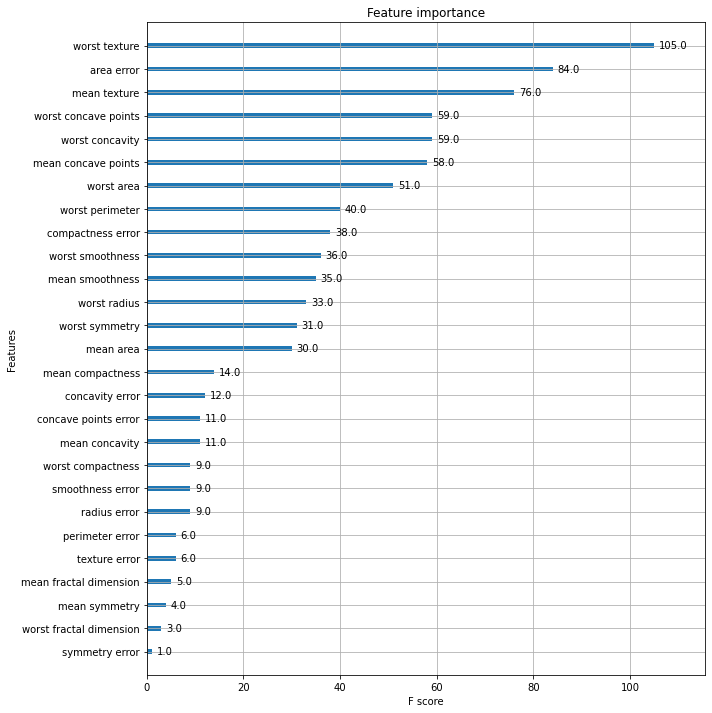

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

- plot_importance(): 피처의 중요도를 막대 그래프 형식으로 나타냄 
  - 기본 평가 지표: f1 스코어 
  - 학습이 완료된 모델 객체 및 맷플롯립의 ax객체를 입력하기만 하면 됨

### 사이킷런 Wrapper XGBoost 개요 및 적용
 - 사이킷런의 기본 Estimator 상속하여 fit()과  predict()만으로 학습과 예측 가능
 - GridSearchCV, pipeline 등 다른 유틸리티 사용
 - XGBClassfier: 분류를 위한 래퍼 클래스
 - XGBRegressor: 회귀를 위한 래퍼 클래스

#### **XGBClassfier**
- 호환성을 유지하기 위해 xgboost에서 사용하던 네이티브 하라미터 몇 개 변경 
  - eta -> learnig_rate
  - sub_sample -> subsample
  - lambda -> reg_lambda
  - alpha -> reg_alpha

 
- n_estimators와 num_boost_round 파이퍼 파라미터는 서로 동일한 파라미터이기 때문에 두 개가 동시에 사용되면 n_estimators 적용 (XGBoost에서는 num_boost_round 적용)

In [15]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미 입력해도 수행에 문제 없음.   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [16]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


#### **조기 중단: early stopping을 50으로 설정하고 재 학습/예측/평가**
- early_stopping_rounds: 평가 지표가 향상될 수 있는 반복 횟수 정의
- eval_metric: 조기 중단을 위한 평가 지표
- eval_set: 성능 평가를 수행할 데이터 세트(학습데이터가 아닌 별도의 데이터 세트)

In [17]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_train, y_train), (X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65036	validation_1-logloss:0.65225
[1]	validation_0-logloss:0.61149	validation_1-logloss:0.61502
[2]	validation_0-logloss:0.57605	validation_1-logloss:0.58135
[3]	validation_0-logloss:0.54363	validation_1-logloss:0.55064
[4]	validation_0-logloss:0.51420	validation_1-logloss:0.52296
[5]	validation_0-logloss:0.48669	validation_1-logloss:0.49707
[6]	validation_0-logloss:0.46158	validation_1-logloss:0.47278
[7]	validation_0-logloss:0.43824	validation_1-logloss:0.45139
[8]	validation_0-logloss:0.41552	validation_1-logloss:0.43122
[9]	validation_0-logloss:0.39504	validation_1-logloss:0.41151
[10]	validation_0-logloss:0.37558	validation_1-logloss:0.39413
[11]	validation_0-logloss:0.35801	validation_1-logloss:0.37800
[12]	validation_0-logloss:0.34099	validation_1-logloss:0.36290
[13]	validation_0-logloss:0.32512	validation_1-logloss:0.34888
[14]	validation_0-logloss:0.31038	validation_1-logloss:0.33513
[15]	validation_0-logloss:0.29641	validation_1-logloss:0.32292
[1

- 다음 예제에서는 평가를 위한 데이터 세트로 테스트 데이터 세트 사용 
- 테스트 데이터 세트는 학습 시에는 완전히 알려지지 않은 데이터 사용 
- 평가에 테스트 데이터 세트를 사용하면 학습 시 미리 참고가 되어 과적합 가능 

In [18]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9951


In [19]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)


[0]	validation_0-logloss:0.65036	validation_1-logloss:0.65225
[1]	validation_0-logloss:0.61149	validation_1-logloss:0.61502
[2]	validation_0-logloss:0.57605	validation_1-logloss:0.58135
[3]	validation_0-logloss:0.54363	validation_1-logloss:0.55064
[4]	validation_0-logloss:0.51420	validation_1-logloss:0.52296
[5]	validation_0-logloss:0.48669	validation_1-logloss:0.49707
[6]	validation_0-logloss:0.46158	validation_1-logloss:0.47278
[7]	validation_0-logloss:0.43824	validation_1-logloss:0.45139
[8]	validation_0-logloss:0.41552	validation_1-logloss:0.43122
[9]	validation_0-logloss:0.39504	validation_1-logloss:0.41151
[10]	validation_0-logloss:0.37558	validation_1-logloss:0.39413
[11]	validation_0-logloss:0.35801	validation_1-logloss:0.37800
[12]	validation_0-logloss:0.34099	validation_1-logloss:0.36290
[13]	validation_0-logloss:0.32512	validation_1-logloss:0.34888
[14]	validation_0-logloss:0.31038	validation_1-logloss:0.33513
[15]	validation_0-logloss:0.29641	validation_1-logloss:0.32292
[1

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

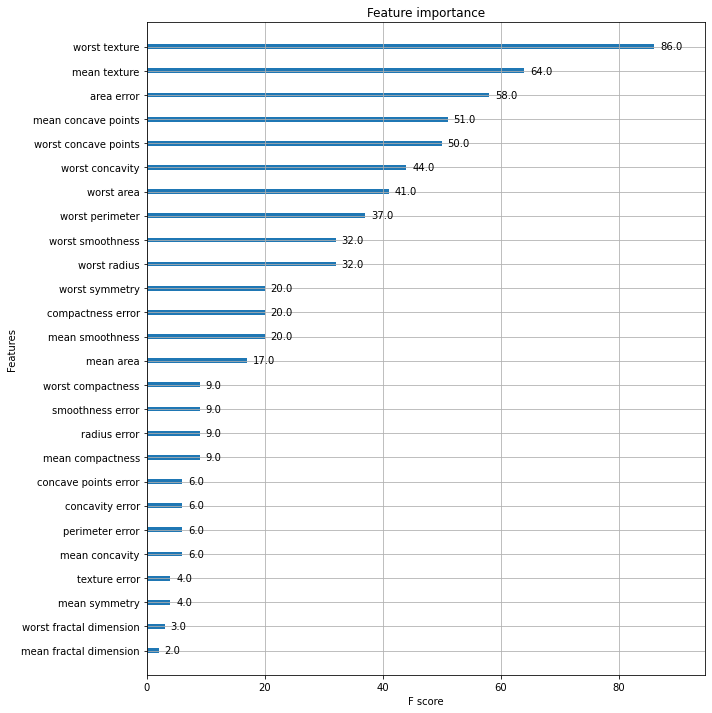

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

## 07 LightGBM

#### **리프 중심 트리 분할(Leaf Wise)**

균형 트리 분할(Levle Wise)| 리프 중심 트리 분할(Leaf Wise)
-|-
최대한 균형 잡힌 트리를 유지하면서 분할| 최대 손실 값을 가지는 리프 노드를 지속적 분할 
 ->트리의 깊이 최소화|-> 깊이가 깊어지고 비대칭적
오버피팅에 강한 구조| 예측 오류 손실 최소화
균형을 맞추기 위한 시간 ↑|

#### **LightGBM 장점**
-  더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용 
- 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

In [21]:
import lightgbm

print(lightgbm.__version__)

3.3.2


#### **LightGBM 적용 – 위스콘신 Breast Cancer Prediction**

In [22]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target

cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [23]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리  
# X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train,test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_train, y_train), (X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.62499	valid_1's binary_logloss: 0.600521
[2]	training's binary_logloss: 0.587995	valid_1's binary_logloss: 0.566786
[3]	training's binary_logloss: 0.555412	valid_1's binary_logloss: 0.537032
[4]	training's binary_logloss: 0.525887	valid_1's binary_logloss: 0.510051
[5]	training's binary_logloss: 0.497961	valid_1's binary_logloss: 0.484612
[6]	training's binary_logloss: 0.473236	valid_1's binary_logloss: 0.462044
[7]	training's binary_logloss: 0.449603	valid_1's binary_logloss: 0.441736
[8]	training's binary_logloss: 0.428129	valid_1's binary_logloss: 0.423503
[9]	training's binary_logloss: 0.406968	valid_1's binary_logloss: 0.404695
[10]	training's binary_logloss: 0.388569	valid_1's binary_logloss: 0.389195
[11]	training's binary_logloss: 0.369851	valid_1's binary_logloss: 0.373406
[12]	training's binary_logloss: 0.352413	valid_1's binary_logloss: 0.35902
[13]	training's binary_logloss: 0.337422	valid_1's binary_logloss: 0.347118
[14]	training's binary_

In [24]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9923


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

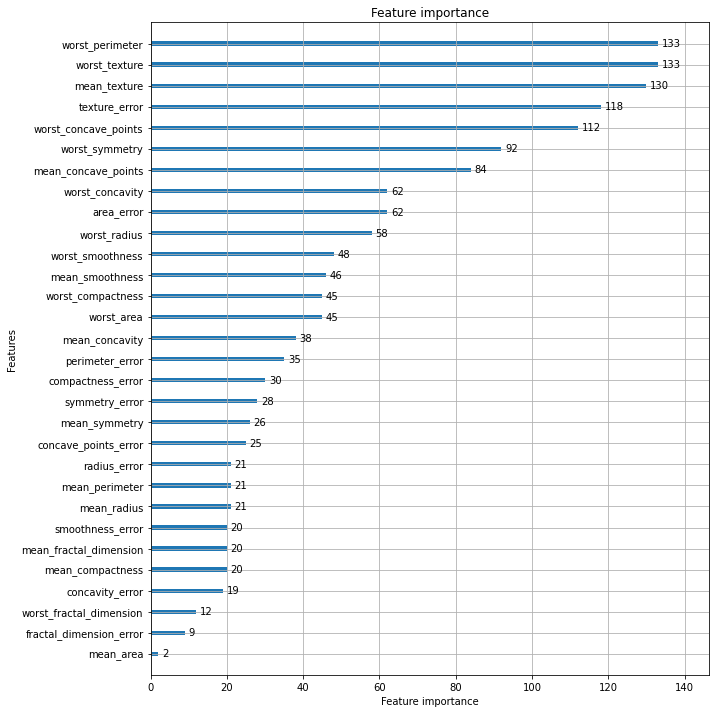

In [25]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(lgbm_wrapper, ax=ax)

## 08 분류 실습 - 캐글 산탄데르 고객 만족 예측

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [27]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [28]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [29]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [30]:
cust_df['var3'].replace(-999999, 2, inplace=True) # var3 피처 값 대체
cust_df.drop('ID', axis=1, inplace=True) # ID 피처 드롭

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [31]:
X_features

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000
76016,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000
76017,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000
76018,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000


In [32]:
y_labels

0        0
1        0
2        0
3        0
4        0
        ..
76015    0
76016    0
76017    0
76018    0
76019    0
Name: TARGET, Length: 76020, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


- 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도를 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출 

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [37]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82072	validation_1-auc:0.81848
[1]	validation_0-auc:0.83539	validation_1-auc:0.83078
[2]	validation_0-auc:0.84073	validation_1-auc:0.83395
[3]	validation_0-auc:0.84583	validation_1-auc:0.84040
[4]	validation_0-auc:0.84938	validation_1-auc:0.84427
[5]	validation_0-auc:0.85320	validation_1-auc:0.84681
[6]	validation_0-auc:0.85661	validation_1-auc:0.85132
[7]	validation_0-auc:0.86029	validation_1-auc:0.85372
[8]	validation_0-auc:0.86299	validation_1-auc:0.85780
[9]	validation_0-auc:0.86641	validation_1-auc:0.86011
[10]	validation_0-auc:0.86875	validation_1-auc:0.86345
[11]	validation_0-auc:0.87212	validation_1-auc:0.86546
[12]	validation_0-auc:0.87545	validation_1-auc:0.86955
[13]	validation_0-auc:0.87775	validation_1-auc:0.87256
[14]	validation_0-auc:0.87992	validation_1-auc:0.87348
[15]	validation_0-auc:0.88248	validation_1-auc:0.87655
[16]	validation_0-auc:0.88450	validation_1-auc:0.87742
[17]	validation_0-auc:0.88583	validation_1-auc:0.87816
[18]	validation_0-au

In [38]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 튜닝 수행 
#속도를 향상시키기 위해 100으로 감소 
ygb_clf=XGBClassifier(n_estimators=100)
params={'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

gridcv=GridSearchCV(xgb_clf,param_grid=params,cv=3)
gridcv.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.70321	validation_1-auc:0.69566
[1]	validation_0-auc:0.79862	validation_1-auc:0.78703
[2]	validation_0-auc:0.80273	validation_1-auc:0.79126
[3]	validation_0-auc:0.81042	validation_1-auc:0.79116
[4]	validation_0-auc:0.80988	validation_1-auc:0.78662
[5]	validation_0-auc:0.82811	validation_1-auc:0.80570
[6]	validation_0-auc:0.83522	validation_1-auc:0.81220
[7]	validation_0-auc:0.84269	validation_1-auc:0.81860
[8]	validation_0-auc:0.84616	validation_1-auc:0.82252
[9]	validation_0-auc:0.84379	validation_1-auc:0.82098
[10]	validation_0-auc:0.85106	validation_1-auc:0.82780
[11]	validation_0-auc:0.85043	validation_1-auc:0.82537
[12]	validation_0-auc:0.85696	validation_1-auc:0.82527
[13]	validation_0-auc:0.85680	validation_1-auc:0.82346
[14]	validation_0-auc:0.85954	validation_1-auc:0.82513
[15]	validation_0-auc:0.85965	validation_1-auc:0.82488
[16]	validation_0-auc:0.86321	validation_1-auc:0.82632
[17]	validation_0-auc:0.86346	validation_1-auc:0.82749
[18]	validation_0-au

NameError: name 'lgbm_clf' is not defined

## 09 분류실습 - 캐글 신용카드 사기 검출 

### 언더 샘플링과 오버 샘플링의 이해 
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제 발생 -> 이상 레이블이 정상 레이블보다 매우 적기 때문에 정상 레이블로 치우친 학습을 해 이상 데이터 검출 어려워짐

#### **언더샘플링**
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소 
- 너무 많은 정상 레이블 데이터를 감소시키기 때문에 제대로 된 학습을 수행하기 어려움

#### **오버 샘플링**
- 적은 데이터 세트를 많은 데이터 세트 수준으로 증식
- 동일한 데이터를 증식하는 방법은 과적합이기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경
- SMOTE: 적은 데이터 세트에 있는 개별 데이터들의 knn을 찾아서 이 데이터와 k개의 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차ㅏ이가 나는 새로운 데이터 생성하는 방식

In [54]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [55]:
card_df.shape

(284807, 31)

#### **원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환**

In [56]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

#### **학습과 테스트 데이터 세트를 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출**

In [82]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [59]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### **로지스틱**

In [85]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727


#### **앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성**

In [86]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

#### **LightGBM 학습/예측/평가**

LightGBM 2.1.0 이상 버전에서 boost_from_average가 True가 Default가 됨. boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨. 레이블 값이 극도로 불균형할 경우 boost_from_average를 False로 설정하는 것이 유리

In [88]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### 데이터 분포도 변환 후 모델 학습/예측/평가
- 중요 feature의 분포도 확인

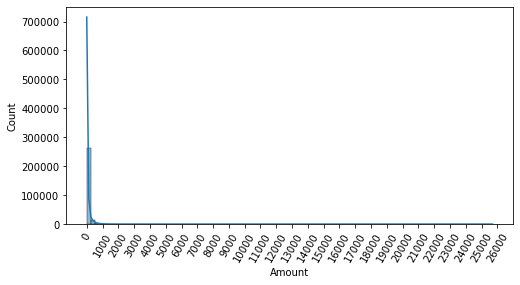

In [89]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

- 데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환

In [90]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

- StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [91]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


#### **Amount를 로그 변환**

**로그 변환** → 데이터 분포도가 심하게 왜곡되어 있을 경우 적용 
- 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 젼환하여 데이터 분포도의 왜곡을 상당 수준 개선


In [107]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [108]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


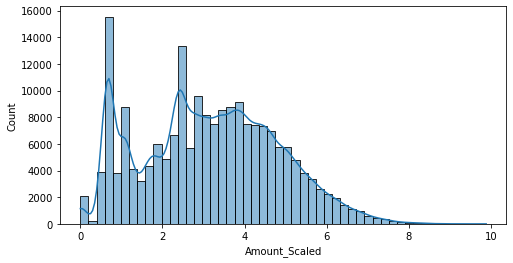

In [94]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(X_train['Amount_Scaled'], bins=50, kde=True)
plt.show()

### 이상치 데이터 제거 후 모델 학습/예측/평가

#### **이상치 데이터(outlier)**
- 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터 

#### **IQR**
- 사분위 값의 편차를 이용하는 기법

<AxesSubplot:>

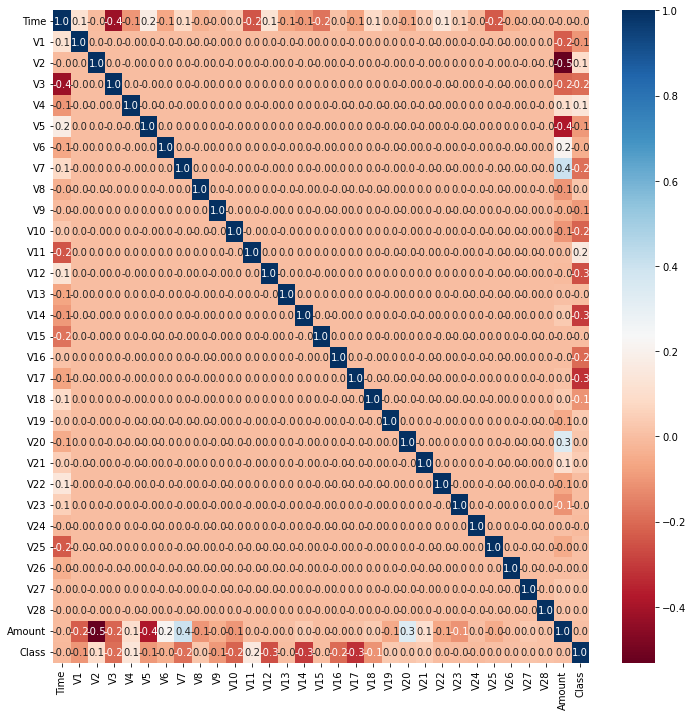

In [95]:
import seaborn as sns

plt.figure(figsize=(12, 12))
corr = card_df.corr()
sns.heatmap(corr, annot=True, fmt='.1f',  cmap='RdBu')

In [96]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [97]:
np.percentile(card_df['V14'].values, 75)

0.493149849218149

In [98]:
np.percentile(card_df['V14'].values, 100)
np.max(card_df['V14'].values)
quantile_25 = np.percentile(card_df['V14'].values, 25)
quantile_75 = np.percentile(card_df['V14'].values, 75)
print(quantile_25, quantile_75)

-0.4255740124549935 0.493149849218149


In [99]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [100]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [101]:
import imblearn

print(imblearn.__version__)

0.7.0


In [102]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [103]:
lr_clf = LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


- 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터 유형보다 너무 많은 Class=1 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 됨 

-> 이걸 해결할 수 있는 방법?

In [104]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

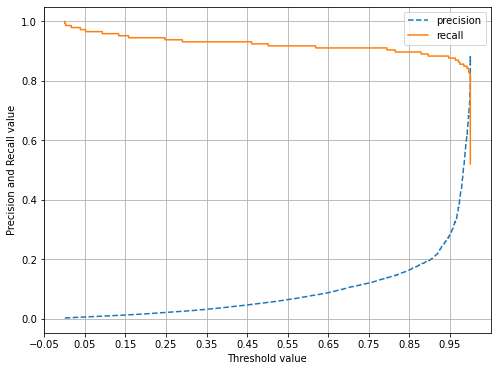

In [105]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [106]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


## 10 스태킹 앙상블

- 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행 
- 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 알고리즘으로 최송 학습 수행 -> 테스트 데이터를 기반으로 다시 최종 예측 수행
- 스태킹 모델은 개별적인 기반 모델과 최종 메타 모델 차이 
np.percentile(card_df['V14'].values, 75)

In [68]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression()

In [69]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [70]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [75]:
ada_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1])

In [71]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [76]:
pred

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1,

In [72]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


- 개별 모델의 정확도보다 향상 (무조건적인 것은 아님)

### CV 셋 기반의 Stacking

- 과적합 개선을 휘새 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 사용

#### **스텝1**
- 각 모델별로 원본 학습/ 테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/ 테스트용 데이터 생성
## ↓

#### **스텝2**
- 스텝1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성합니다. 
- 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터를 생성합니다.
- 메타 모델은 퇴종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가합니다.


In [73]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [74]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [78]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [79]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
